In [1]:
import sys
sys.path.insert(0, '../')
from util import util
import numpy as np
import scipy.stats as st

import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats.mstats import gmean

Text(0.5,1,'Possible beta distributions')

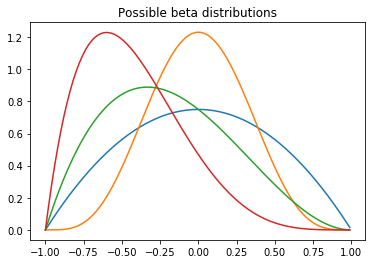

In [2]:
# plot the pdf within the range
x = np.arange (-1, 1, 0.01)

Y1 = st.beta(a = 2,b=2,loc=-1,scale=2)
z = Y1.pdf(x)
plt.plot(x,z)

Y2 = st.beta(a = 5,b=5,loc=-1,scale=2)
z = Y2.pdf(x)
plt.plot(x,z)

Y3 = st.beta(a = 2,b=3,loc=-1,scale=2)
z = Y3.pdf(x)
plt.plot(x,z)

Y4 = st.beta(a = 2,b=5,loc=-1,scale=2)
z = Y4.pdf(x)
plt.plot(x,z)
plt.title("Possible beta distributions")

In [3]:
def fit_beta(Y,n_samples,x_values,fit_type,plot_observed=False,**kwargs):
    #fig, axs = plt.subplots(4,5, figsize=(15, 15), facecolor='w', edgecolor='k')
    #fig.subplots_adjust(hspace = .5, wspace=.001)
    fig, axs = plt.subplots(2,5, figsize=(12, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()
    for i in range(10):
        S = Y.rvs(n_samples)
        for ele in fit_type:
            if ele.lower() == 'mle':
                # fit a beta distribution using MLE
                a1, b1, loc1, scale1 = st.beta.fit(S,**kwargs)

                fitted_beta = st.beta(a = a1,b=b1,loc=loc1,scale=scale1)

                #plt.hist(S,normed=True)

                y_values = fitted_beta.pdf(x_values)
            elif ele.lower() == 'kde':
                # fit a kde, optimising bandwidth
                fitted = st.gaussian_kde(S,bw_method='scott')
                y_values = fitted.pdf(x_values)
            elif ele.lower() == 'mse':
                params = st.beta.fit(S,**kwargs)
                a1,b1,loc1,scale1 = minimize(maximum_spacing,params,args=(S)).x
                fitted_beta = st.beta(a=a1,b=b1,loc=loc1,scale=scale1)
                y_values = fitted_beta.pdf(x_values)
            else:
                raise ValueError("Not a valid estimation method")
            
            axs[i].plot(x_values, y_values,label=ele)
            
        if plot_observed:
            axs[i].hist(S,normed=True,label='Observed samples')
        axs[i].plot(x_values, Y.pdf(x_values),label='True pdf')
        axs[i].yaxis.set_visible(False)
    axs[i].legend()

In [4]:
def sampleSpacings(x):
    #calculates the sample spacings of X
    D=[xi-x[i] for i,xi in enumerate(x[1:])]
    return np.array(D)

def maximum_spacing(parameters,samples):
    # sort the samples
    orderedSample=np.sort(samples)
    
    # obtain the cdf of samples
    sample_cdf = st.beta.cdf(orderedSample,parameters[0],
                          parameters[1],parameters[2],parameters[3])
    # get the spacings
    spacings = sampleSpacings(sample_cdf)
    
    # we maximise (min) the (negative) log of geometric mean of spacing
    return -np.log(gmean(spacings))

/usr/local/lib/python2.7/dist-packages/scipy/stats/stats.py:313: RuntimeWarning: divide by zero encountered in log
  log_a = np.log(a)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/scipy/optimize/optimize.py:643: RuntimeWarning: invalid value encountered in double_scalars
  grad[k] = (f(*((xk + d,) + args)) - f0) / d[k]


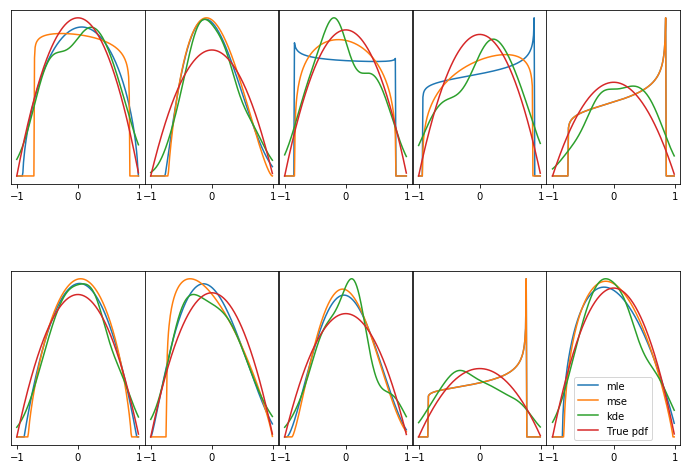

In [5]:
fit_beta(Y1,50,x,['mle','mse','kde'])
#fit_beta(Y1,50,x,'kde')
#fit_beta(Y1,50,x,'mse')

In [6]:
N = [25,50,100]
n_iter = 500
n_samples = 10000

In [7]:
# simple quadratic cost function
# f1 = lambda x,y: -x*y + 0.2*x**2 
f1 = lambda x,y: -x*y + 5*x**2 + 2*x 

f3 = lambda x,y: 3*x**2 + 6*x*y**2 - 2*x**2*y - 7*x*y

f2 = lambda x,y: -x*y + 0.2*x**2

In [8]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [9]:
def minimise_dist(distribution,function,n_samples=10000):
    # minimises a cost function according to a given distribution
    samples = distribution.rvs(size=n_samples)
    
    # minimise the cost function
    res = minimize(function,0.0,args=(samples))
    return res.x

In [10]:
# concave function in x
f1_mean = lambda x,y: np.mean(f1(x,y),axis=0)
f2_mean = lambda x,y: np.mean(f2(x,y),axis=0)
f3_mean = lambda x,y: np.mean(f3(x,y),axis=0)

In [11]:
def minimise_methods(distribution,function,N,n_iter=500,n_samples=5000):
    results = np.zeros((5,n_iter,len(N)))
    for k in range(n_iter):
        for j in range(len(N)):
            # obtain the samples
            S = distribution.rvs(N[j])

            # maximise using SAA
            results[0,k,j]= minimize(function,0.0,args=(S)).x


            # fit a beta distribution using MLE
            a1, b1, loc1, scale1 = st.beta.fit(S)
            fitted = st.beta(a = a1,b=b1,loc=loc1,scale=scale1)
            samples = fitted.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[1,k,j] = res.x
            
            # fit distribution using kde
            fitted = st.gaussian_kde(S,bw_method='scott')
            samples = fitted.resample(size=n_samples)
            res = minimize(function,0.0,args=(np.reshape(samples,(-1))))
            results[2,k,j] = res.x
            
            # fit distribution using maximum spacing estimation
            params = [a1, b1, loc1, scale1]
            a,b,loc,scale = minimize(maximum_spacing,params,args=(S),
                                        bounds=((0,None),(0,None),(None,None),
                                               (None,None))).x
            fitted_beta = st.beta(a=a,b=b,loc=loc,scale=scale)
            samples = fitted_beta.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[3,k,j] = res.x
            
            # fit beta using MLE with fixed support
            a1, b1,loc1,scale1= st.beta.fit(S,floc=-1,fscale=2)
            fitted = st.beta(a = a1,b=b1,loc=-1,scale=2)
            samples = fitted.rvs(size=n_samples)
            res = minimize(function,0.0,args=(samples))
            results[4,k,j] = res.x
    return results

In [12]:
def plot_result(results,plot_histogram=False,y_label='average expected cost'):
    plt.figure(figsize=(10,5))
    if plot_histogram:
        for i in range(results.shape[0]):
            plt.hist(results[i,:,0],bins=30,normed=True,alpha=1.0/(i+1))
            plt.title("Distribution of x_star for N=25")
    else:
        mean=np.mean(results,axis=1)
        std=np.std(results,axis=1)
        for i in range(results.shape[0]):
            #plt.plot(N,mean[i])
            plt.errorbar(N, mean[i], yerr=std[i],capsize=5)
        plt.xlabel('No of samples')
        plt.ylabel(y_label)
    plt.legend(['SAA','MLE','KDE','MSE','fixed support MSE'])

## Results 2.1
These are the results for: <br>
            <center>$ 5x^2 -xy + 2x $</center>

Text(0.5,0,'y')

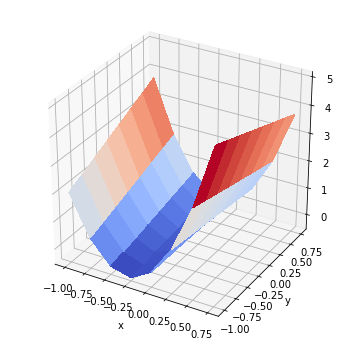

In [13]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f1(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [14]:
results1 = minimise_methods(Y1,f1_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/scipy/stats/_continuous_distns.py:427: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [15]:
def calculate_expected_cost(x_star_array,distribution,function,n_samples=10000):
    """
    we calculate the expected cost for a given x*, cost function and
    beta distribution using monte carlo
    """
    samples = distribution.rvs(n_samples)
    expected_cost = np.mean(function(np.reshape(x_star_array,(-1,1)),samples),axis=1)
    return np.reshape(expected_cost,x_star_array.shape)

In [16]:
expected_cost1 = calculate_expected_cost(results1,Y1,f1)

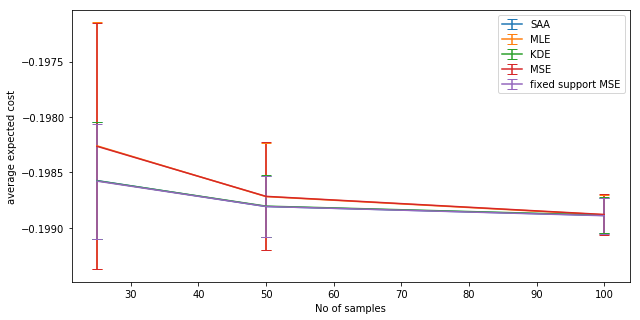

In [17]:
plot_result(expected_cost1)

In [18]:
results2 = minimise_methods(Y2,f1_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/scipy/optimize/minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


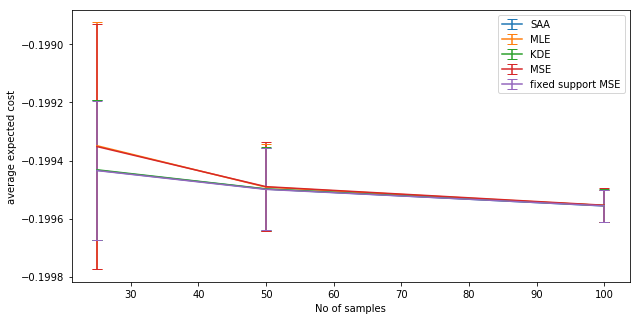

In [19]:
expected_cost2 = calculate_expected_cost(results2,Y2,f1)
plot_result(expected_cost2)

In [20]:
results3 = minimise_methods(Y3,f1_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


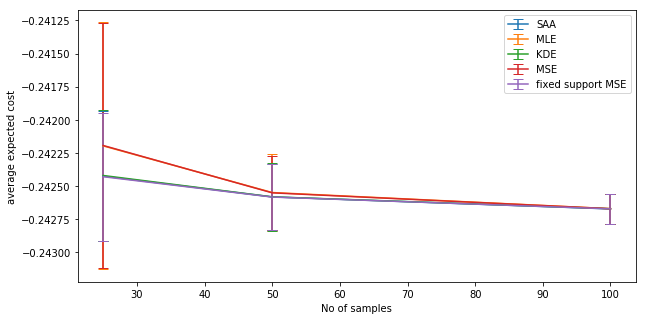

In [21]:
expected_cost3 = calculate_expected_cost(results3,Y3,f1)
plot_result(expected_cost3)

In [22]:
results4 = minimise_methods(Y4,f1_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


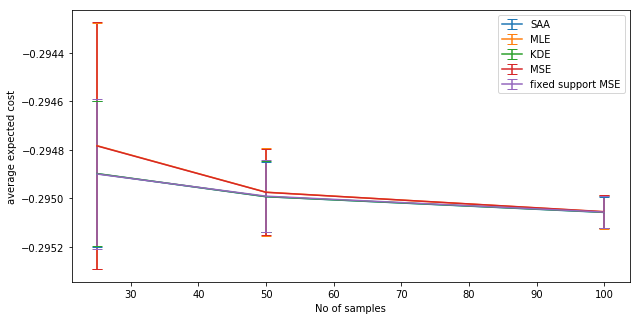

In [23]:
expected_cost4 = calculate_expected_cost(results4,Y4,f1)
plot_result(expected_cost4)

## Results 2.2
These are the results for: <br>
            <center>$0.2x^2 -xy $</center>

Text(0.5,0,'y')

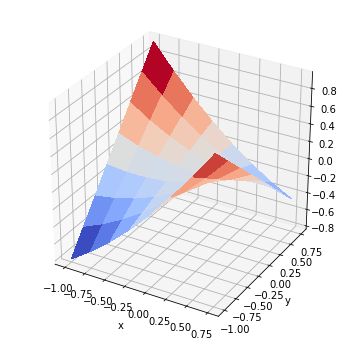

In [24]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f2(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [25]:
results1_f2 = minimise_methods(Y1,f2_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


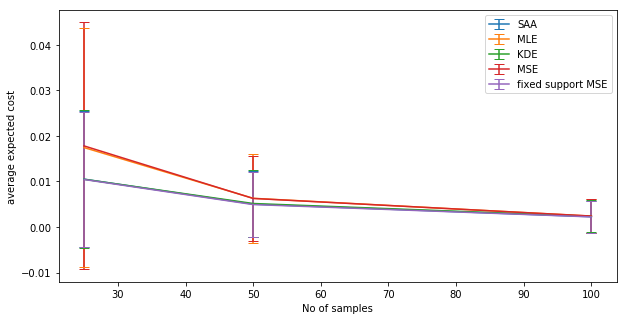

In [26]:
expected_cost1_f2 = calculate_expected_cost(results1_f2,Y1,f2)
plot_result(expected_cost1_f2)

In [27]:
results2_f2 = minimise_methods(Y2,f2_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/usr/local/lib/python2.7/dist-packages/scipy/stats/_distn_infrastructure.py:1738: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= self.b) & cond0


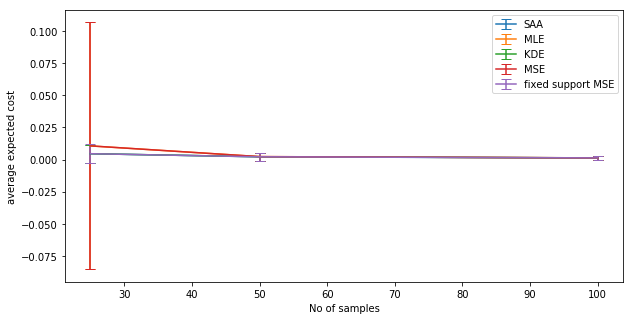

In [28]:
expected_cost2_f2 = calculate_expected_cost(results2_f2,Y2,f2)
plot_result(expected_cost2_f2)

In [29]:
results3_f2 = minimise_methods(Y3,f2_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


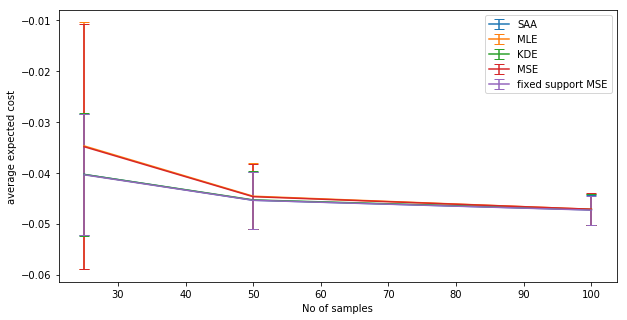

In [30]:
expected_cost3_f2 = calculate_expected_cost(results3_f2,Y3,f2)
plot_result(expected_cost3_f2)

In [31]:
results4_f2 = minimise_methods(Y4,f2_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


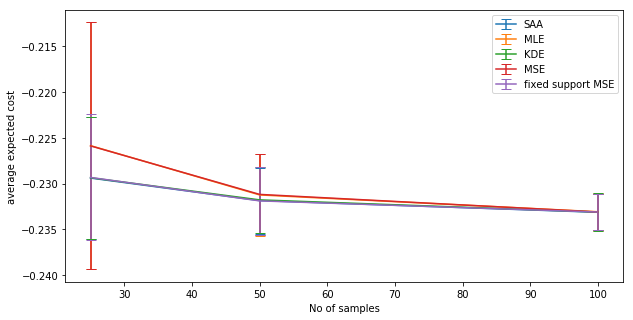

In [32]:
expected_cost4_f2 = calculate_expected_cost(results4_f2,Y4,f2)
plot_result(expected_cost4_f2)

## Results
These are the results for: <br>
            <center>$ 3x^2 + 6xy^2 - 2x^2y - 7xy $</center>

Text(0.5,0,'y')

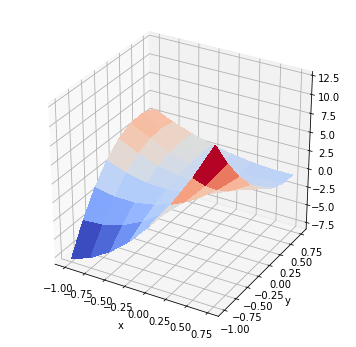

In [33]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
Z = f3(X,Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax.set_xlabel("x")
ax.set_ylabel("y")

In [34]:
results1_f3 = minimise_methods(Y1,f3_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


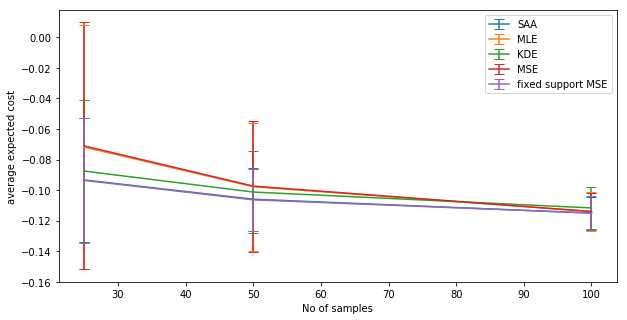

In [35]:
expected_cost1_f3 = calculate_expected_cost(results1_f3,Y1,f3)
plot_result(expected_cost1_f3)

In [36]:
results2_f3 = minimise_methods(Y2,f3_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


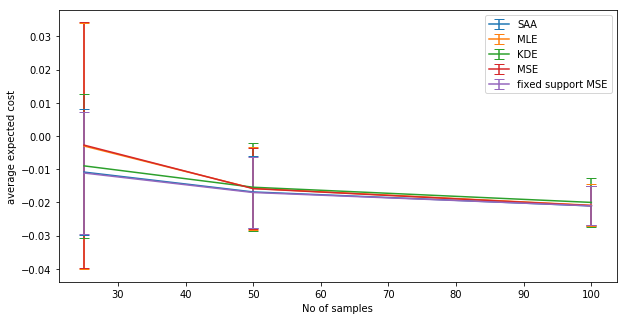

In [37]:
expected_cost2_f3 = calculate_expected_cost(results2_f3,Y2,f3)
plot_result(expected_cost2_f3)

In [38]:
results3_f3 = minimise_methods(Y3,f3_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


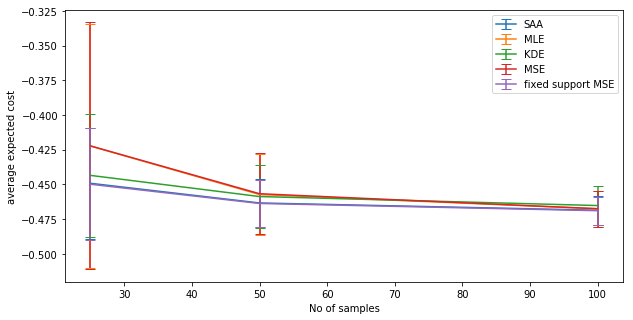

In [39]:
expected_cost3_f3 = calculate_expected_cost(results3_f3,Y3,f3)
plot_result(expected_cost3_f3)

In [40]:
results4_f3 = minimise_methods(Y4,f3_mean,N,n_iter)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log


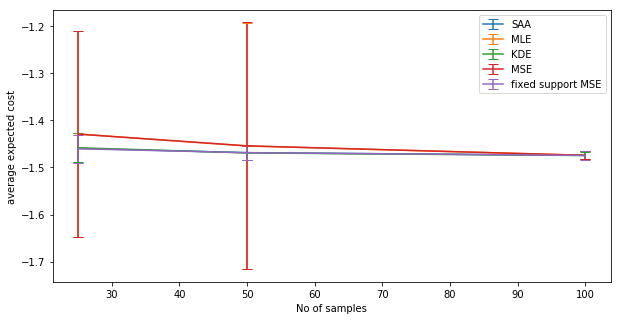

In [41]:
expected_cost4_f3 = calculate_expected_cost(results4_f3,Y4,f3)
plot_result(expected_cost4_f3)